# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## Settings

In [42]:
# CONTROLS
MODEL_PREFIX = "V06"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.1
MIN_LR = 1e-6
MAX_LR = 1e-4
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 20
CLR_METHOD = "triangular" # exp_range, triangular, triangular2
NUM_EPOCHS = 40
MODE = "binary" # "binary", "categorical"

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import pickle, os, sys, re

import spacy
from spacy.lang.en import English

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [3]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import Data

In [5]:
df = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16},
                 encoding="utf8")

df2 = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16})

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(5)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID  \
count   27481        
unique  27481        
top     d5e35a43d6   
freq    1            

                                                                                                                text  \
count   27480                                                                                                          
unique  27480                                                                                                          
top     Did you know call of duty has a scenario game called 'Nazi zombies?' it`s awesome and scary at the same time   
freq    1                                                                                                              

       selected_text sentiment  
count   27480         27481     
unique  22463

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [6]:
test_df = pd.read_csv("../data/test.csv", dtype={"time":np.float64,"signal":np.float64})
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(5)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID                                text sentiment
count   3534        3534                                3534    
unique  3534        3534                                3       
top     5b5be601c2  farewelling an employee tonight...  neutral 
freq    1           1                                   1430    


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
df.loc[df2['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)]

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral
432,1a88179ebb,"I love mine, too . happy motherï¿½s day to your mom , John Taylor . much love to you, too .","I love mine, too . happy motherï¿½s day to your mom , John Taylor . much love to you, too",positive
645,532d442071,meeting just in time that iï¿½m trying to win something prize`s friday!,meeting just in time that iï¿½m trying to win something prize`s friday!,neutral
854,2617b9c9e3,Just got confirmed that itï¿½s pizza-time with some ex co-workers on friday...looking forward to it,looking forward to it,positive
...,...,...,...,...
26472,68a56eca92,"..uuuups today is mother day???....sh***....iï¿½ve forgot it, my work doesnï¿½t have a end *sigh*....thank you for remind it","..uuuups today is mother day???....sh***....iï¿½ve forgot it, my work doesnï¿½t have a end *sigh*....thank you for remind it",neutral
26745,bfe8f0ab98,i canï¿½t choose one i love all the songs on LV&TT;bt if u like... Read More: http://is.gd/JkVF,i love all the songs,positive
26882,336b9cfc93,XDXDXD you crazy little thing why didnï¿½t you get off the train and hug me????,DXD you crazy little thing why didnï¿½t you get off the train and hug me???,neutral
27087,c2c5b285b9,Shared Kim Hï¿½ltermand - Portfolio: Shared by Kaare Finally a dane IÂ´ve got the honor to do the amazing.. http://tinyurl.com/coypsl,honor,positive


In [8]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)]

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive
800,f5e9c0eef2,I would vote for you Miley but I live in Ireland You`ll be fine Good luck! Slï¿½n!(bye in irish ) Sorcha xxxx,positive
1150,6e60ed6d59,So disappointed about the talent lineup for 'Reventï¿½n Super Estrella 2009'...hmm...Have the feeling I won`t get tix this time around.,negative
1644,fc6128f4e5,"ok i just spent like ï¿½50 on soundtracks, a galaxy class starship and EVE online. sigh",neutral
1730,440e8fc447,Hockey was so fukinï¿½ good **** you hole! xD,neutral
1857,2f8250d0df,the day goes on and on...i think im gonna write a song about it! still thinking itï¿½s impossible for me to get a true friend why????,negative
1864,9d187014d5,Good morning... Iï¿½m soooo tierd,neutral
1976,a9da40eedd,"Oh, final msg - Why didn`t you review my boardgame Bookchaseï¿½ when you were on telly? We didn`t even get a nice letter..",negative
1990,e162b84433,Start of diet today I think I have to face I will never get back down to 77kilos (unless I cut a leg off)ï¿½,negative


## Exploration

#### Sentiment count in training

In [9]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [10]:
anomalous_idxs = [27302, 18, 27, 149, 160, 251, 295, 309, 398, 458, 492, 581, 637, 639, 678, 757, 787, 863, 1077, 1096, 1157, 1376, 1393, 1420, 1515, 1518, 1693, 1696, 1728, 1754, 1798, 1929, 2008, 2056, 2124, 2136, 2187, 2213, 2324, 2364, 2392, 2401, 2439, 2440, 2785, 2787, 2986, 3319, 3363, 3369, 3399, 3400, 3411, 3473, 4148, 4369, 4404, 4576, 4639, 4654, 4747, 5167, 5189, 5196, 5213, 5241, 5358, 5361, 5510, 5530, 5560, 5687, 5697, 5712, 5751, 6113, 6131, 6230, 6261, 6360, 6528, 6540, 6627, 6686, 6724, 6759, 6804, 6859, 6948, 6987, 7024, 7040, 7331, 7409, 7438, 7442, 7506, 7513, 7530, 7642, 7663, 7818, 7837, 8005, 8049, 8052, 8153, 8161, 8235, 8249, 8497, 8569, 8594, 8624, 8691, 8706, 8720, 8749, 8803, 8999, 9113, 9190, 9374, 9442, 9449, 9496, 9535, 9539, 9594, 9631, 9696, 9882, 10007, 10050, 10070, 10164, 10293, 10411, 10492, 10508, 10521, 10530, 10672, 10747, 10813, 10935, 10968, 10981, 10986, 11176, 11228, 11300, 11323, 11349, 11353, 11480, 11588, 11643, 11698, 11706, 11745, 11861, 11963, 11985, 12138, 12205, 12283, 12356, 12397, 12416, 12474, 12522, 12563, 12576, 12662, 12736, 12803, 12843, 12972, 12977, 13004, 13124, 13237, 13365, 13379, 13605, 13637, 13704, 13796, 13803, 13907, 13965, 13975, 14058, 14213, 14230, 14257, 14275, 14571, 14611, 14779, 14855, 14880, 15010, 15056, 15165, 15207, 15372, 15462, 15528, 15562, 15660, 15998, 16117, 16175, 16352, 16372, 16391, 16423, 16493, 16500, 16570, 16643, 16665, 16720, 16726, 16876, 16915, 17013, 17029, 17062, 17160, 17404, 17412, 17417, 17513, 17530, 17531, 17600, 17627, 17729, 17762, 17893, 17945, 17986, 18003, 18086, 18099, 18314, 18342, 18355, 18375, 18536, 18616, 18778, 18862, 18908, 18912, 18930, 18997, 19028, 19057, 19162, 19213, 19239, 19274, 19279, 19405, 19431, 19481, 19486, 19536, 19562, 19634, 19651, 19754, 19963, 19985, 19988, 20014, 20216, 20299, 20394, 20440, 20451, 20506, 20644, 20865, 20895, 21013, 21018, 21114, 21205, 21316, 21331, 21349, 21376, 21556, 21737, 21755, 21876, 21923, 22117, 22205, 22234, 22280, 22363, 22365, 22378, 22383, 22387, 22536, 22588, 22717, 22744, 22768, 22769, 22836, 22864, 22938, 23081, 23108, 23145, 23199, 23205, 23290, 23352, 23372, 23528, 23617, 23630, 23680, 23690, 23733, 23746, 23784, 23842, 23959, 24026, 24046, 24274, 24378, 24476, 24490, 24502, 24504, 24597, 24682, 24753, 24766, 24886, 24909, 24996, 25104, 25267, 25338, 25380, 25422, 25446, 25486, 25499, 25601, 25691, 25712, 25732, 25760, 25908, 25947, 25996, 26017, 26025, 26256, 26268, 26625, 26643, 26677, 26687, 26762, 26781, 26830, 26870, 26882, 26927, 27067, 27121, 27209, 27229, 27280, 27349, 27362, 27386, 27401]

In [11]:
df = df[(~df.index.isin(anomalous_idxs)) & (~df.selected_text.isna())].copy()

In [12]:
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [13]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [14]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

In [15]:
def add_special_tokens(x, is_target=False):
    x = x.lower()
    x = re.sub('([!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n])', ' \\1 ', x) # Not including ` here since used in couldn`t isn`t
    if is_target:
        x = x.split(" ")
    else:
        x = ["xxxSTART"] + x.split(" ") + ["xxxEND"]
    x = " ".join(x)
    x = re.sub(' +', ' ', x)
    return x

In [16]:
df["text"] = df["text"].apply(lambda x: add_special_tokens(x, is_target=False))
df["selected_text"] = df["selected_text"].apply(lambda x: add_special_tokens(x, is_target=True))
test_df["text"] = test_df["text"].apply(lambda x: add_special_tokens(x, is_target=False))

#### Tokenization

In [17]:
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [18]:
df['text_t'] = df['text'].apply(lambda x: tokenizer(x))
df['selected_text_t'] = df['selected_text'].apply(lambda x: tokenizer(x))
test_df['text_t'] = test_df['text'].apply(lambda x: tokenizer(x))

In [19]:
X_words = [[word.orth_ if not word.like_url else 'xxxURL' for word in row] for row in df['text_t']]
Y_words = [[word.orth_ if not word.like_url else 'xxxURL' for word in row] for row in df['selected_text_t']]
X_test_words = [[word.orth_ if not word.like_url else 'xxxURL' for word in row] for row in test_df['text_t']]

print(len(X_words), len(Y_words), len(X_test_words))

27088 27088 3534


In [20]:
from collections import Counter
word_counts = Counter([j for i in X_words for j in i])

X_unique_tokens = len(word_counts)
word_counts.most_common(10)

[('.', 34974),
 ('xxxSTART', 27088),
 ('xxxEND', 27088),
 ('!', 15031),
 ('i', 14274),
 ('to', 9881),
 ('the', 8897),
 (',', 8374),
 ('a', 6714),
 ('my', 5487)]

In [21]:
list_of_words = set(sorted([j for i in X_words + X_test_words for j in i]))
Y_list_of_words = set(sorted([j for i in Y_words for j in i]))

In [22]:
vocab_itos = {i+2:j for i,j in enumerate(list_of_words)}
vocab_stoi = {j:i+2 for i,j in enumerate(list_of_words)}

vocab_stoi["xxxUNK"] = 1
vocab_itos[1] = "xxxUNK"

vocab_stoi["xxxNone"] = 0
vocab_itos[0] = "xxxNone"

In [23]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = vocab_stoi["xxxUNK"]
    return value

In [24]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
Y2 = [[1 if j in y else 0 for j in X[i]] for i,y in enumerate(Y)]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_test_words]

In [25]:
max_len = max([len(i) for i in X])
max_len_y = max([len(i) for i in Y2])
VOCAB_SIZE = len(vocab_stoi)
print(VOCAB_SIZE, max_len, max_len_y)

28226 108 108


#### Test Train split

In [26]:
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO * len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

27088 21670 5418 27088


In [27]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_sentiments_train, X_sentiments_val = [X_sentiments[i] for i in train_idx], [X_sentiments[i] for i in val_idx]
X_sentiments_train, X_sentiments_val = np.array(X_sentiments_train, dtype=np.int32), np.array(X_sentiments_val, dtype=np.int32)
Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y2_train, Y2_val = [Y2[i] for i in train_idx], [Y2[i] for i in val_idx]

[len(i) for i in [X_train, X_val, X_sentiments_train, X_sentiments_val, Y_train, Y_val, Y2_train, Y2_val]]

[21670, 5418, 21670, 5418, 21670, 5418, 21670, 5418]

#### Padding

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y2_train = pad_sequences(Y2_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y2_val = pad_sequences(Y2_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")

In [30]:
print(X_train.shape, X_sentiments_train.shape, X_val.shape, X_sentiments_val.shape, X_test.shape)
print(Y_train.shape, Y2_train.shape, Y_val.shape, Y2_val.shape)

(21670, 108) (21670,) (5418, 108) (5418,) (3534, 108)
(21670, 108) (21670, 108) (5418, 108) (5418, 108)


#### Checking for zero input vectors

In [31]:
keep_x_train = X_train.sum(axis=1) > 0
X_train, Y_train = X_train[keep_x_train], Y_train[keep_x_train]
X_sentiments_train, Y2_train = X_sentiments_train[keep_x_train], Y2_train[keep_x_train]

keep_x_val = X_val.sum(axis=1) > 0
X_val, Y_val = X_val[keep_x_val], Y_val[keep_x_val]
X_sentiments_val, Y2_val = X_sentiments_val[keep_x_val], Y2_val[keep_x_val]

keep_x_test = X_test.sum(axis=1) > 0
test_df["kept"] = keep_x_test
X_test, X_sentiments_test = X_test[keep_x_test], X_sentiments_test[keep_x_test]

In [32]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 36903
0 36903


## Combined Sentiment Model

In [33]:
input_sentiments = Input((max_len))

emb_sentiments = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64, mask_zero=True)(input_sentiments)

sentiments = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(emb_sentiments)
sentiments = BatchNormalization()(sentiments)
sentiments = Dropout(DROPOUT)(sentiments)

sentiments = Bidirectional(LSTM(16, activation='relu'))(sentiments)
sentiments = BatchNormalization()(sentiments)
sentiments = Dropout(DROPOUT)(sentiments)

sentiments = Flatten()(sentiments)

sentiments = Dense(16, activation="relu")(sentiments)
sentiments = BatchNormalization()(sentiments)

output_sentiments = Dense(3, activation="softmax")(sentiments)

In [34]:
model_sentiments = Model(input_sentiments, output_sentiments)
model_sentiments.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 108)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 108, 64)           1806464   
_________________________________________________________________
bidirectional (Bidirectional (None, 108, 32)           10368     
_________________________________________________________________
batch_normalization (BatchNo (None, 108, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 108, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

In [35]:
adam_sentiments = Adam(learning_rate=MIN_LR)

model_sentiments.compile(loss='sparse_categorical_crossentropy',
                         optimizer=adam_sentiments, metrics=['accuracy'])

In [36]:
#callbacks
mcp_sentiments = ModelCheckpoint(filepath="../results/SentimentModel_"+MODEL_PREFIX+"Checkpoint.h5",
                                 monitor='val_loss',
                                 mode="auto",
                                 save_weights_only=False,
                                 save_best_only=True)

clr_sentiments = CyclicLR(mode=CLR_METHOD,
                          base_lr=MIN_LR,
                          max_lr=MAX_LR,
                          step_size= STEP_SIZE * (np.concatenate((X_train,
                                                                  X_test), axis=0).shape[0] // BATCH_SIZE))

In [37]:
history_sentiments = model_sentiments.fit(x=np.concatenate((X_train,
                                                            X_test), axis=0),
                                          y=np.concatenate((X_sentiments_train,
                                                            X_sentiments_test), axis=0),
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          epochs=60, #NUM_EPOCHS,
                                          validation_data=(X_val, X_sentiments_val),
                                          verbose=1,
                                          callbacks=[clr_sentiments, mcp_sentiments])

Train on 25204 samples, validate on 5418 samples
Epoch 1/60
25204/25204 [==============================] - 21s 851us/sample - loss: 1.4943 - accuracy: 0.3190 - val_loss: 1.0981 - val_accuracy: 0.3882
Epoch 2/60
25204/25204 [==============================] - 15s 608us/sample - loss: 1.4644 - accuracy: 0.3271 - val_loss: 1.0990 - val_accuracy: 0.3176
Epoch 3/60
25204/25204 [==============================] - 15s 593us/sample - loss: 1.4478 - accuracy: 0.3241 - val_loss: 1.1009 - val_accuracy: 0.2818
Epoch 4/60
25204/25204 [==============================] - 15s 592us/sample - loss: 1.4041 - accuracy: 0.3376 - val_loss: 1.1035 - val_accuracy: 0.2761
Epoch 5/60
25204/25204 [==============================] - 15s 599us/sample - loss: 1.3588 - accuracy: 0.3493 - val_loss: 1.1067 - val_accuracy: 0.2757
Epoch 6/60
25204/25204 [==============================] - 15s 592us/sample - loss: 1.3139 - accuracy: 0.3597 - val_loss: 1.1098 - val_accuracy: 0.2757
Epoch 7/60
25204/25204 [=====================

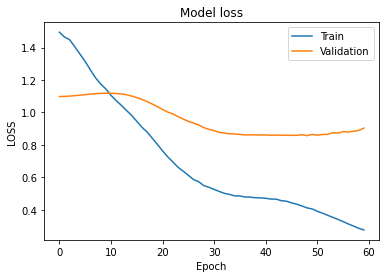

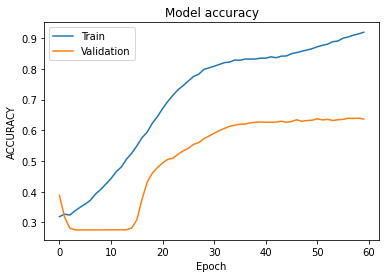

In [38]:
metric_names = ['loss' ,'accuracy']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history_sentiments.history[i])
    plt.plot(history_sentiments.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [33]:
from tensorflow.keras.models import load_model

model_sentiments = tf.keras.models.load_model(
    filepath="../results/SentimentModel_"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True
)

In [34]:
sentiment_model_embeddings = model_sentiments.layers[1].get_weights()[0]

In [35]:
conf_mat_train = confusion_matrix(X_sentiments_train,
                                  model_sentiments.predict(X_train, batch_size=2048).argmax(axis=1))

conf_mat_val = confusion_matrix(X_sentiments_val,
                                model_sentiments.predict(X_val, batch_size=2048).argmax(axis=1))

conf_mat_test = confusion_matrix(X_sentiments_test,
                                 model_sentiments.predict(X_test, batch_size=2048).argmax(axis=1))

In [36]:
conf_mat_train, conf_mat_val, conf_mat_test

(array([[1666, 2083, 2409],
        [2339, 3324, 3178],
        [2192, 2250, 2229]], dtype=int64),
 array([[429, 513, 552],
        [573, 806, 811],
        [523, 605, 606]], dtype=int64),
 array([[264, 357, 380],
        [358, 533, 539],
        [361, 368, 374]], dtype=int64))

## Model

In [43]:
input_sentiment = Input((1))
input_sequences = Input((max_len))

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64,
                          weights=[sentiment_model_embeddings], mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

senti = Dense(8, activation="relu")(input_sentiment)
senti = BatchNormalization()(senti)
senti = Dropout(DROPOUT)(senti)
senti = RepeatVector(max_len)(senti)

concat_layer = concatenate([senti, seq])

seq = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(concat_layer)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

output = LSTM(max_len, activation='sigmoid')(seq)

In [44]:
model = Model([input_sentiment, input_sequences], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 108)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 108, 64)      1806464     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 108, 32)      10368       embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [45]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

In [46]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [47]:
history = model.fit(x=[X_sentiments_train, X_train],
                    y=Y2_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=([X_sentiments_val, X_val], Y2_val),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

## Might need a callback as described here 
##https://stackoverflow.com/questions/51728648/how-do-masked-values-affect-the-metrics-in-keras
#history = model.fit(x=[X_sentiments_train, X_train],
#                    y=Y_train,
#                    shuffle=True,
#                    batch_size=BATCH_SIZE,
#                    epochs=NUM_EPOCHS,
#                    validation_data=([X_sentiments_val, X_val], Y_val),
#                    verbose=1,
#                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp, 

Train on 21670 samples, validate on 5418 samples
Epoch 1/40
21670/21670 [==============================] - 32s 1ms/sample - loss: 0.5348 - accuracy: 0.8279 - val_loss: 0.4985 - val_accuracy: 0.9155
Epoch 2/40
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.5303 - accuracy: 0.8328 - val_loss: 0.4950 - val_accuracy: 0.9161
Epoch 3/40
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.5234 - accuracy: 0.8403 - val_loss: 0.4898 - val_accuracy: 0.9162
Epoch 4/40
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.5138 - accuracy: 0.8481 - val_loss: 0.4831 - val_accuracy: 0.9162
Epoch 5/40
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.5008 - accuracy: 0.8609 - val_loss: 0.4753 - val_accuracy: 0.9162
Epoch 6/40
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.4878 - accuracy: 0.8710 - val_loss: 0.4667 - val_accuracy: 0.9162
Epoch 7/40
21670/21670 [==============================] -

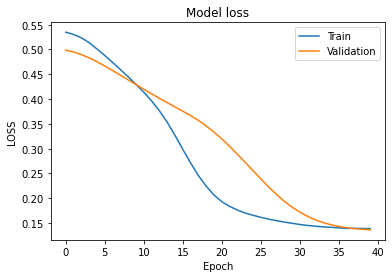

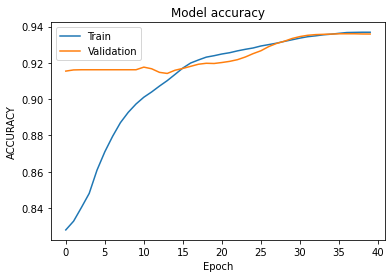

In [48]:
metric_names = ['loss' ,'accuracy']
#metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [63]:
history = model.fit(x=[X_sentiments_train, X_train],
                    y=Y2_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS*3,
                    validation_data=([X_sentiments_val, X_val], Y2_val),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

## Might need a callback as described here 
##https://stackoverflow.com/questions/51728648/how-do-masked-values-affect-the-metrics-in-keras
#history = model.fit(x=[X_sentiments_train, X_train],
#                    y=Y_train,
#                    shuffle=True,
#                    batch_size=BATCH_SIZE,
#                    epochs=NUM_EPOCHS,
#                    validation_data=([X_sentiments_val, X_val], Y_val),
#                    verbose=1,
#                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp, 

Train on 21670 samples, validate on 5418 samples
Epoch 1/120
21670/21670 [==============================] - 28s 1ms/sample - loss: 0.1385 - accuracy: 0.9373 - val_loss: 0.1350 - val_accuracy: 0.9360
Epoch 2/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.1379 - accuracy: 0.9374 - val_loss: 0.1337 - val_accuracy: 0.9362
Epoch 3/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.1366 - accuracy: 0.9379 - val_loss: 0.1324 - val_accuracy: 0.9365
Epoch 4/120
21670/21670 [==============================] - 22s 995us/sample - loss: 0.1357 - accuracy: 0.9383 - val_loss: 0.1310 - val_accuracy: 0.9370
Epoch 5/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.1342 - accuracy: 0.9390 - val_loss: 0.1295 - val_accuracy: 0.9374
Epoch 6/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.1322 - accuracy: 0.9400 - val_loss: 0.1278 - val_accuracy: 0.9380
Epoch 7/120
21670/21670 [========================

Epoch 55/120
21670/21670 [==============================] - 22s 999us/sample - loss: 0.0721 - accuracy: 0.9710 - val_loss: 0.0992 - val_accuracy: 0.9570
Epoch 56/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.0711 - accuracy: 0.9713 - val_loss: 0.1011 - val_accuracy: 0.9567
Epoch 57/120
21670/21670 [==============================] - 21s 979us/sample - loss: 0.0703 - accuracy: 0.9716 - val_loss: 0.0996 - val_accuracy: 0.9565
Epoch 58/120
21670/21670 [==============================] - 21s 983us/sample - loss: 0.0695 - accuracy: 0.9719 - val_loss: 0.1002 - val_accuracy: 0.9564
Epoch 59/120
21670/21670 [==============================] - 22s 992us/sample - loss: 0.0693 - accuracy: 0.9719 - val_loss: 0.1008 - val_accuracy: 0.9559
Epoch 60/120
21670/21670 [==============================] - 22s 993us/sample - loss: 0.0683 - accuracy: 0.9725 - val_loss: 0.0998 - val_accuracy: 0.9559
Epoch 61/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0

Epoch 109/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.0546 - accuracy: 0.9778 - val_loss: 0.1143 - val_accuracy: 0.9516
Epoch 110/120
21670/21670 [==============================] - 21s 981us/sample - loss: 0.0544 - accuracy: 0.9780 - val_loss: 0.1137 - val_accuracy: 0.9517
Epoch 111/120
21670/21670 [==============================] - 21s 974us/sample - loss: 0.0542 - accuracy: 0.9781 - val_loss: 0.1140 - val_accuracy: 0.9517
Epoch 112/120
21670/21670 [==============================] - 24s 1ms/sample - loss: 0.0542 - accuracy: 0.9782 - val_loss: 0.1142 - val_accuracy: 0.9518
Epoch 113/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.0540 - accuracy: 0.9783 - val_loss: 0.1142 - val_accuracy: 0.9518
Epoch 114/120
21670/21670 [==============================] - 22s 1ms/sample - loss: 0.0542 - accuracy: 0.9782 - val_loss: 0.1141 - val_accuracy: 0.9517
Epoch 115/120
21670/21670 [==============================] - 22s 996us/sample - loss

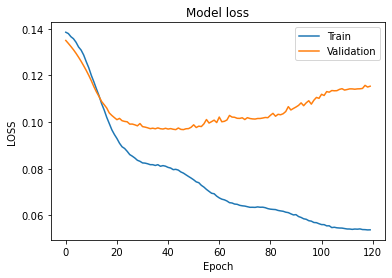

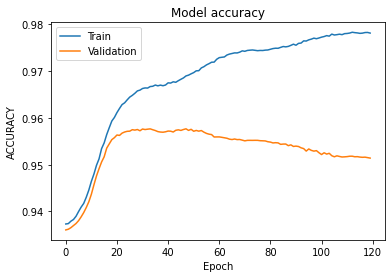

In [64]:
metric_names = ['loss' ,'accuracy']
#metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [65]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True
)

In [66]:
model.evaluate(x = [X_sentiments_val, X_val], y=Y2_val, batch_size=PREDICT_BATCH_SIZE)

5418/5418 [==============================] - 2s 308us/sample - loss: 0.0968 - accuracy: 0.9574


[0.09676739545150541, 0.9573593]

In [67]:
pred_train = model.predict(x = [X_sentiments_train, X_train], batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = [X_sentiments_val, X_val], batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = [X_sentiments_test, X_test], batch_size=PREDICT_BATCH_SIZE)

In [68]:
X_train.shape, Y_train.shape, pred_train.shape

((21670, 108), (21670, 108), (21670, 108))

In [69]:
# Accuracy is not a good metric
print("Min Accuracy: TRAINING: \t", np.sum(Y_train == 0) / (Y_train.shape[0] * Y_train.shape[1]))
print("Min Accuracy: VALIDATION: \t", np.sum(Y_val == 0) / (Y_val.shape[0] * Y_val.shape[1]))

Min Accuracy: TRAINING: 	 0.9182993214719103
Min Accuracy: VALIDATION: 	 0.918165443036244


#### Postprocessing

In [70]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

In [71]:
pred_train_words = [i[j>0.5].tolist() for i,j in zip(X_train, pred_train)]
pred_val_words = [i[j>0.5].tolist() for i,j in zip(X_val, pred_val)]
pred_test_words = [i[j>0.5].tolist() for i,j in zip(X_test, pred_test)]

#### Spot Checks

In [72]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Sentiment:")
        print('\t', sent_labels[X_sentiments_train[index_to_check]])
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', [get_from_vocab(vocab_itos,j) for j in pred_train_words[index_to_check]])
        print("Predictions:")
        print('\t',*[["%.2f"%j,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Sentiment:")
        print('\t', sent_labels[X_sentiments_val[index_to_check]])
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', [get_from_vocab(vocab_itos,j) for j in pred_val_words[index_to_check]])
        print("Predictions:")
        print('\t',*[["%.2f"%j,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                             pred_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Sentiment:")
        print('\t', sent_labels[X_sentiments_test[index_to_check]])
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', [get_from_vocab(vocab_itos,j) for j in pred_test_words[index_to_check]])
        print("Predictions:")
        print('\t',*[["%.2f"%j,
                      i,
                      X_test_words[index_to_check][num]] for num, (i,j) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                         pred_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [73]:
for i in range(10,20):
    spot_check(i, mode="train")

================== Sample # 10 ==================
Sentiment:
	 positive
Selected_text:
	 ['love']
Predicted_text:
	 []
Predictions:
	
	['0.00', 8475, 'xxxSTART']
	['0.41', 980, 'digging']
	['0.44', 4019, 'a']
	['0.30', 14722, 'downloaded']
	['0.20', 9124, 'film']
	['0.17', 14432, 'with']
	['0.18', 13502, 'mi']
	['0.20', 18901, 'familia']
	['0.11', 17855, '.']
	['0.11', 19296, 'we']
	['0.04', 20841, 'love']
	['0.05', 6129, 'itunes']
	['0.02', 27877, 'xxxEND']
================== Sample # 11 ==================
Sentiment:
	 negative
Selected_text:
	 ['b', 'i', 'missed', 'it', '.']
Predicted_text:
	 [',', 'rob']
Predictions:
	
	['0.00', 8475, 'xxxSTART']
	['0.50', 23370, 'shoot']
	['0.57', 7502, ',']
	['0.50', 25749, 'rob']
	['0.49', 24757, 'i']
	['0.43', 9317, 'missed']
	['0.45', 4944, 'it']
	['0.37', 17855, '.']
	['0.24', 19497, 'just']
	['0.19', 596, 'got']
	['0.15', 20844, 'home']
	['0.15', 17855, '.']
	['0.07', 27877, 'xxxEND']
================== Sample # 12 ==================
Sentimen

In [74]:
for i in range(200,210):
    spot_check(i, mode="validation")

================== Sample # 200 ==================
Sentiment:
	 negative
Selected_text:
	 ['imissu', ',']
Predicted_text:
	 ['imissu', ',', 'come', 'back', 'home', 'now']
Predictions:
	
	['0.00', 8475, 'xxxSTART']
	['0.79', 11100, 'imissu']
	['0.78', 7502, ',']
	['0.88', 6645, 'come']
	['0.83', 8737, 'back']
	['0.81', 20844, 'home']
	['0.63', 4977, 'now']
	['0.49', 14358, 'honey']
	['0.29', 27877, 'xxxEND']
================== Sample # 201 ==================
Sentiment:
	 negative
Selected_text:
	 ['you', 'don`t', 'do', 'sympathy', 'very', 'well']
Predicted_text:
	 ['you`re', 'right', '-', 'you']
Predictions:
	
	['0.00', 8475, 'xxxSTART']
	['0.58', 9675, 'you`re']
	['0.61', 4814, 'right']
	['0.51', 14248, '-']
	['0.52', 2483, 'you']
	['0.48', 27716, 'don`t']
	['0.40', 19273, 'do']
	['0.36', 305, 'sympathy']
	['0.21', 1318, 'very']
	['0.20', 22817, 'well']
	['0.12', 27877, 'xxxEND']
================== Sample # 202 ==================
Sentiment:
	 negative
Selected_text:
	 ['sorry', ',', 't

In [75]:
for i in range(10,20):
    spot_check(i, mode="test")

================== Sample # 10 ==================
Sentiment:
	 negative
Selected_text:
	 Not Available
Predicted_text:
	 []
Predictions:
	
	['0.00', 8475, 'xxxSTART']
	['0.38', 25120, 'my']
	['0.48', 6976, 'bike']
	['0.39', 23187, 'was']
	['0.37', 5575, 'put']
	['0.29', 22428, 'on']
	['0.41', 21500, 'hold']
	['0.25', 17855, '.']
	['0.30', 17855, '.']
	['0.19', 17855, '.']
	['0.27', 8655, 'should']
	['0.29', 23767, 'have']
	['0.17', 25210, 'known']
	['0.19', 15760, 'that']
	['0.13', 17855, '.']
	['0.07', 17855, '.']
	['0.08', 17855, '.']
	['0.06', 17855, '.']
	['0.05', 14961, 'argh']
	['0.03', 3826, 'total']
	['0.03', 5895, 'bummer']
	['0.02', 27877, 'xxxEND']
================== Sample # 11 ==================
Sentiment:
	 neutral
Selected_text:
	 Not Available
Predicted_text:
	 ['i', 'checked', '.', 'we', 'didn`t']
Predictions:
	
	['0.00', 8475, 'xxxSTART']
	['0.85', 24757, 'i']
	['0.89', 17027, 'checked']
	['0.75', 17855, '.']
	['0.72', 19296, 'we']
	['0.61', 26189, 'didn`t']
	['0.45',

In [76]:
def jaccard(str1, str2): 
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [77]:
print("Training Jaccard Score", np.mean([jaccard(str1=i[i>0], str2=j) for i,j in zip(Y_train,pred_train_words)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i[i>0], str2=j) for i,j in zip(Y_val,pred_val_words)]))

Training Jaccard Score 0.46451942576009936
Validation Jaccard Score 0.4080849459101457


In [78]:
# Average number of words in selected text?
pd.Series([len(i) for i in Y]).describe()

count    27088.000000
mean     8.826565    
std      8.630794    
min      1.000000    
25%      2.000000    
50%      6.000000    
75%      13.000000   
max      106.000000  
dtype: float64

In [116]:
# is it generally predicting words that are in itself??
np.mean([sum([1  if (k in j) else 0 for k in i])/len(i) if len(i)!=0 else 0 for i,j in zip(pred_val_words, Y_val)])

0.46093712464715814

In [ ]:
[(sent_labels[X_sentiments_test[num]], [get_from_vocab(vocab_itos,j) for j in i]) for num, i in enumerate(pred_test_words[:5])]

In [ ]:
def post_process(x):
    x = "".join(x)
    x = re.sub(pattern="xxxSTART", repl="", string=x)
    x = re.sub(pattern="xxxEND", repl="", string=x)
    return x

In [ ]:
pred_train_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_train_words]
pred_val_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_val_words]
pred_test_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_test_words]

In [ ]:
a = pred_val_words[300]
print([vocab_itos[i] for i in X_val[300] if i!=0])
print([vocab_itos[i] for i in Y_val[300] if i!=0])
print(pred_val_words[300])
print(post_process(a))

In [ ]:
post_process(pred_test_words[18])

In [ ]:
[[post_process(i)] for num, i in enumerate(pred_test_words)]

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
def jaccard(str1, str2):
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
len(train_idx), keep_x_train.shape, pred_train.shape

In [ ]:
predictions = pd.DataFrame({
    "pred_selected_text" : pred_train_words + pred_val_words,
    "original_index" : np.concatenate((np.array(train_idx, dtype=np.int64)[keep_x_train],
                                       np.array(val_idx, dtype=np.int64)[keep_x_val])),
    "set" : ["train" for i in range(sum(keep_x_train))] + ["val" for i in range(sum(keep_x_val))]
})

In [ ]:
assert (predictions.original_index.min(), predictions.original_index.max()) == (df.original_index.min(), df.original_index.max())

In [ ]:
print(df.shape, predictions.shape)
results = pd.merge(df, predictions, on = "original_index", how="inner")
print(df.shape, predictions.shape, results.shape)

In [ ]:
results.loc[results.set=="val"].head(10)

In [ ]:
results.loc[results.set=="train"].head(10)

In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))
print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/ConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/ConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')

In [ ]:
from tensorflow.keras.models import load_model

best_model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True,
    custom_objects = {'macro_soft_f1':macro_soft_f1, 'macro_f1':macro_f1}
)

In [ ]:
pred_train = best_model.predict(x = X_train, batch_size=PREDICT_BATCH_SIZE)
pred_val = best_model.predict(x = X_val, batch_size=PREDICT_BATCH_SIZE)
pred_test = best_model.predict(x = X_test, batch_size=PREDICT_BATCH_SIZE)

In [ ]:
pred_train = pred_train.argmax(axis=1)
pred_val = pred_val.argmax(axis=1)
pred_test = pred_test.argmax(axis=1)

In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))

print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/BestConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/BestConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/best_submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')